# DataLab Cup 1 
[Kaggle](https://www.kaggle.com/competitions/2023-datalab-cup1-predicting-news-popularity/data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

In [2]:
# load csv file
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print(f"{train.shape=}")
print(f"{train.columns=}")

train.shape=(27643, 3)
train.columns=Index(['Id', 'Popularity', 'Page content'], dtype='object')


#### Function Helper

hashing on the content,
sentiment on the topic
then append the day.

In [4]:
# train.iloc[27628,:]

In [5]:
# soup = BeautifulSoup(train['Page content'][27628], 'html.parser')
# print(soup.prettify())

In [6]:
def get_day_time(datetime_value):
    """Extract the day of the week and time from a datetime string."""
    day = {'Sun': 0, 'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat':6}
    value = {}

    # Define a regular expression pattern to capture the day of the week and time
    pattern = r'^(\w+), (\d+ \w+ \d{4}) (\d+:\d+)'

    # Use re.search to find a match in the datetime value
    match = re.search(pattern, datetime_value)

    if match:
        value['Day'] = day[match.group(1)]
        if value['Day'] == 0 or value['Day'] == 6:
            value['Day'] = 1
        else:
            value['Day'] = 0
        time = match.group(3).split(':')
        value['Time'] = (int(time[0]) *60 + int(time[1])) / 1440.0
        # date = match.group(2)
    else:
        value['Day'] = 0
        value['Time'] = 0
        # date = np.nan
    
    return value
    
def chunk(iterable, chunk_size):
    """Generates lists of `chunk_size` elements from `iterable`.
    
    
    >>> list(chunk((2, 3, 5, 7), 3))
    [[2, 3, 5], [7]]
    >>> list(chunk((2, 3, 5, 7), 2))
    [[2, 3], [5, 7]]
    """
    iterable = iter(iterable)
    while True:
        chunk = []
        try:
            for _ in range(chunk_size):
                chunk.append(next(iterable))
            yield chunk
        except StopIteration:
            if chunk:
                yield chunk
            break

In [7]:
def preprocessor(text):
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text
def tokenizer(text):
    return re.split('\s+', text.strip())

from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords

def tokenizer_stem(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in re.split('\s+', text.strip())]


nltk.download([
    "names",
    "stopwords",
    "movie_reviews",
    "averaged_perceptron_tagger",
    "vader_lexicon",
    "punkt",
])
stop = stopwords.words('english')
def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package names to /home/jojo/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jojo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jojo/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jojo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jojo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/jojo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


author is too hard

In [8]:
from icecream import ic
def preprocess(data):
    soup = BeautifulSoup(data, 'html.parser')

    title = soup.find('h1', class_='title').text
    day = "Mon"
    day_time = {'Day': 0, 'Time': 0}
    try:
        day = soup.find('time').get('datetime')
        day_time = get_day_time(day)
    except:
        pass

    content_element = soup.find('section', class_='article-content')
    content = content_element.text
    # links = soup.find_all('a')
    # try:
    #     links = len(links)
    # except:
    #     links = 0
    vid = soup.find_all('iframe')
    arr = [title, content, len(content.split()), len(vid), day_time['Day'], day_time['Time']]

    for i in range(1):
        arr[i] = preprocessor(arr[i])

    return arr

In [9]:
feat = ['Title', 'Content', 'WordCount', 'VideoCount', 'Day', 'Time']

### Preprocessing

In [10]:
train_preprocess = train['Page content'].apply(preprocess)
test_preprocess = test['Page content'].apply(preprocess)


In [11]:
feat

['Title', 'Content', 'WordCount', 'VideoCount', 'Day', 'Time']

In [12]:
train_preprocess_df = pd.DataFrame(train_preprocess.to_list(), columns=feat)
test_preprocess_df = pd.DataFrame(test_preprocess.to_list(), columns=feat)

train_preprocess_df = pd.concat([train_preprocess_df, train[['Popularity']]], axis=1)
test_preprocess_df = pd.concat([test_preprocess_df], axis=1)

# scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_preprocess_df[['WordCount', 'VideoCount']] = sc.fit_transform(train_preprocess_df[['WordCount', 'VideoCount']])
test_preprocess_df[['WordCount', 'VideoCount']] = sc.transform(test_preprocess_df[['WordCount', 'VideoCount']])

In [13]:
train_preprocess_df

,Title,Content,WordCount,VideoCount,Day,Time,Popularity
0,nasa s grand challenge stop asteroids from des...,There may be killer asteroids headed for Eart...,0.069157,0.000000,0,0.627778,-1
1,google s new open source patent pledge we won ...,Google took a stand of sorts against patent-l...,0.035626,0.000000,0,0.736111,1
2,ballin 2014 nfl draft picks get to choose thei...,You've spend countless hours training to be a...,0.135355,0.274725,0,0.802083,1
3,cameraperson fails deliver slapstick laughs,Tired of the same old sports fails and ne...,0.032298,0.230769,0,0.101389,-1
4,nfl star helps young fan prove friendship with...,"At 6-foot-5 and 298 pounds, All-Pro NFL star ...",0.166913,0.010989,0,0.146528,-1
...,...,...,...,...,...,...,...
27638,chief of usaid doesn t know who created cuban ...,The chief of the U.S. Agency for Internationa...,0.035380,0.000000,0,0.684722,-1
27639,photo of samsung s rumored virtual reality hea...,"Back in May, reports surfaced claiming that S...",0.037106,0.000000,0,0.043750,-1
27640,14 dogs that frankly cannot take the heat,There's nothing more helpless than the middle...,0.018984,0.000000,0,0.520833,-1
27641,yahoo earnings beat estimates but core problem...,Yahoo's profits in the first quarter beat Wal...,0.051036,0.000000,0,0.867361,-1


In [14]:
train_preprocess_df.to_csv('data/train_preprocess.csv', index=False)
test_preprocess_df.to_csv('data/test_preprocess.csv', index=False)

In [15]:
train_preprocess_df
test_preprocess_df

,Title,Content,WordCount,VideoCount,Day,Time
0,soccer star gets twitter death threats after t...,Note to humanity: One Direction fandom ai...,0.062993,0.076923,0,0.824306
1,google glass gets an accessory store,Shortly after announcing a hardware upgrade f...,0.015533,0.000000,0,0.392361
2,ouya gaming console already sold out on amazon,"Well, that was quick. Just hours after going ...",0.018245,0.000000,0,0.537500
3,between two ferns mocks oscar nominees,Between Two Ferns: Oscar Buzz Edition Part 1...,0.016889,0.043956,0,0.145833
4,american sniper trailer looks like eastwood m...,Ever since The Hurt Locker it seems like ...,0.025025,0.010989,0,0.065278
...,...,...,...,...,...,...
11842,check out twitter co founders beautiful new of...,Some of the creators of Twitter have landed ...,0.013190,0.000000,1,0.875000
11843,fish out of water is an adorably addictive io...,Full disclosure: Jetpack Joyride is still on...,0.067678,0.000000,0,0.793750
11844,if music services influenced grammys this is w...,LOS ANGELES — Nominees for the 56th Grammy Aw...,0.117973,0.241758,0,0.984722
11845,google s nexus 7 comes to europe australia and...,The latest version of Google's Nexus 7 has be...,0.014053,0.000000,0,0.359028


In [26]:
def df_chunk(df, n):
    """Yield successive n-sized chunks from df."""
    for i in range(0, len(df), n):
        yield df.iloc[i:i + n, :]
def transpose(l):
    return list(map(list, zip(*l)))

In [33]:
X_train_content

array([[' There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks and figure out how to stop them from destroying our planet. The new mission builds on projects already underway at NASA, including a plan to capture an asteroid, pull it in toward the moon and send astronauts to visit it. As part of the Grand Challenge, the agency issued a "request for information" today — aiming to solicit ideas from industry, academia and the public on how to improve the asteroid mission plan. "We\'re asking for you to think about concepts and different approaches for what we\'ve described here," William Gerstenmaier, NASA\'s associate administrator for human explorations and operations, said yesterday during a NASA event announcing the initiative. "We want you to think about other ways of enhancing this to get the most out of it." SEE ALSO: How It Works: NASA Asteroid-

In [39]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

X_train_title, y_train = train_preprocess_df['Title'].values, train_preprocess_df['Popularity'].values
X_train_content = train_preprocess_df['Content'].values
X_train_2 = train_preprocess_df[['WordCount', 'VideoCount', 'Day']].values

def train_and_validate_model(X_train, X_train_2, X_train_opt=None, y_train=y_train, batch_size=1000, n_features=2**10, max_iter=20, tol=1e-3):
    hashvec = HashingVectorizer(n_features=n_features, preprocessor=None, tokenizer=tokenizer_stem_nostop)

    # loss='log' gives logistic regression
    clf = SGDClassifier(loss='log_loss', max_iter=max_iter, tol=tol)
    
    stream_X = chunk(X_train, batch_size)
    stream_X2 = chunk(X_train_2, batch_size)
    stream_y = chunk(y_train, batch_size)
    stream_x_opt = chunk(X_train_opt, batch_size) if X_train_opt is not None else None

    classes = np.array([-1, 1])
    train_auc, val_auc = [], []

    # we use one batch for training and another for validation in each iteration
    iters = int((len(X_train) + batch_size - 1) / (batch_size * 2))

    for i in range(iters):
        stream_x_chunk = next(stream_X)
        stream_x2_chunk = next(stream_X2)
        stream_y_chunk = next(stream_y)
        stream_x_opt_chunk = next(stream_x_opt) if stream_x_opt is not None else None
        if stream_x_chunk is None:
            break
        stream_x_chunk = hashvec.transform(stream_x_chunk)
        if stream_x_opt_chunk:
            stream_x_opt_chunk = hashvec.transform(stream_x_opt_chunk)
            stream_train_combined = np.concatenate((stream_x_chunk.toarray(), stream_x_opt_chunk.toarray(), stream_x2_chunk), axis=1)
        else:
            stream_train_combined = np.concatenate((stream_x_chunk.toarray(), stream_x2_chunk), axis=1)

        clf.partial_fit(stream_train_combined, stream_y_chunk, classes=classes)
        train_auc.append(roc_auc_score(stream_y_chunk, clf.predict_proba(stream_train_combined)[:, 1]))

        # validate
        X_val, y_val = next(stream_X), next(stream_y)
        X_val_2 = next(stream_X2)
        X_val_opt = next(stream_x_opt) if stream_x_opt is not None else None


        X_val = hashvec.transform(X_val)
        if X_val_opt:
            X_val_opt = hashvec.transform(X_val_opt)
            X_val_combined = np.concatenate((X_val.toarray(), X_val_opt.toarray(), X_val_2), axis=1)
        else:
            X_val_combined = np.concatenate((X_val.toarray(), X_val_2), axis=1)
        score = roc_auc_score(y_val, clf.predict_proba(X_val_combined)[:, 1])
        val_auc.append(score)
        print('[{}/{}] {}'.format((i + 1) * (batch_size * 2), len(X_train), score))
    
    return train_auc, val_auc, clf

train_auc, val_auc, clf = train_and_validate_model(X_train_title, X_train_2, X_train_content, y_train)


[2000/27643] 0.48590895261885314
[4000/27643] 0.49758488962644953
[6000/27643] 0.4998939995759983
[8000/27643] 0.5225890112704917
[10000/27643] 0.5344087105554995
[12000/27643] 0.5274909896756284
[14000/27643] 0.5325165353574559
[16000/27643] 0.5521838786196303
[18000/27643] 0.511588271301175
[20000/27643] 0.48708135900796445
[22000/27643] 0.5246742123463115
[24000/27643] 0.5373565977055633
[26000/27643] 0.5085060340241361
[28000/27643] 0.5203692593524414


In [40]:
# from sklearn.feature_extraction.text import HashingVectorizer
# from sklearn.linear_model import SGDClassifier
# from sklearn.metrics import roc_auc_score
# import scipy

# hashvec = HashingVectorizer(n_features=2**10,
#                             preprocessor=None, tokenizer=tokenizer_stem_nostop)

# # loss='log' gives logistic regression
# clf = SGDClassifier(loss='log_loss', max_iter=20, tol=1e-3)
# batch_size = 1000
# X_train, y_train = train_preprocess_df['Title'].values, train_preprocess_df['Popularity'].values
# X_train_2 = train_preprocess_df[['Content', 'Video', 'Day']].values
# # print(X_train_2.iloc[:2,:])
# stream_X = chunk(X_train, batch_size)
# stream_X2 = chunk(X_train_2, batch_size)
# stream_y = chunk(y_train, batch_size)

# classes = np.array([-1, 1])
# train_auc, val_auc = [], []
# # we use one batch for training and another for validation in each iteration
# iters = int((25000+batch_size-1)/(batch_size*2))

# for i in range(iters):
#     stream_x_chunk = next(stream_X)
#     stream_x2_chunk = next(stream_X2)
#     stream_y_chunk = next(stream_y)
#     if stream_x_chunk is None:
#         break
#     stream_x_chunk = hashvec.transform(stream_x_chunk)

#     stream_train_combined = np.concatenate((stream_x_chunk.toarray(), stream_x2_chunk), axis=1)
#     clf.partial_fit(stream_train_combined, stream_y_chunk, classes=classes)
#     train_auc.append(roc_auc_score(stream_y_chunk, clf.predict_proba(stream_train_combined)[:,1]))
#     # print(X_train.shape, X_train_2.shape)   

#     # # validate
#     X_val, y_val = next(stream_X), next(stream_y)
#     # print(X_val.shape, X_val_2.shape)
#     X_val_2 = next(stream_X2)


#     X_val = hashvec.transform(X_val)
#     X_val_combined = np.concatenate((X_val.toarray(), X_val_2), axis=1)
#     score = roc_auc_score(y_val, clf.predict_proba(X_val_combined)[:,1])
#     val_auc.append(score)
#     print('[{}/{}] {}'.format((i+1)*(batch_size*2), 25000, score))


In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

hashvec = HashingVectorizer(n_features=2**10, preprocessor=None, tokenizer=tokenizer_stem_nostop)
X_train_combined_ = np.concatenate((hashvec.transform(X_train_title).toarray(), hashvec.transform(X_train_content).toarray(), X_train_2), axis=1)
y_train = train_preprocess_df['Popularity'].values

scores = cross_val_score(estimator=RandomForestClassifier(max_depth=4, random_state=0),
                         X=X_train_combined_, y=y_train,
                         cv=10, scoring='roc_auc')

In [42]:
scores

array([0.54818031, 0.56624458, 0.55319279, 0.53970175, 0.54342643,
       0.55868777, 0.54109946, 0.55318232, 0.55257119, 0.55697848])

In [43]:
forest = RandomForestClassifier(max_depth=4, random_state=0)
forest.fit(X_train_combined_, y_train)

RandomForestClassifier(max_depth=4, random_state=0)

In [46]:
X_train_title, y_train = train_preprocess_df['Title'].values, train_preprocess_df['Popularity'].values
X_train_content = train_preprocess_df['Content'].values
X_train_2 = train_preprocess_df[['WordCount', 'VideoCount', 'Day']].values

X_test_title = test_preprocess_df['Title'].values
X_test_content = test_preprocess_df['Content'].values
X_test_2 = test_preprocess_df[['WordCount', 'VideoCount', 'Day']].values
X_test_combined = np.concatenate((hashvec.transform(X_test_title).toarray(), hashvec.transform(X_test_content).toarray(), X_test_2), axis=1)
y_pred = forest.predict_proba(X_test_combined)
y_pred = y_pred[:,1]
print(y_pred)

[0.49190449 0.49327882 0.48912734 ... 0.48529063 0.48017796 0.48947631]


In [47]:
# write to csv
df = pd.DataFrame({'Id': test['Id'], 'Popularity': y_pred})
df.to_csv('data/submission_new.csv', index=False)

# Unused

In [ ]:
X_test = test_preprocess_new['Content']
X_test = hashvec.transform(X_test)
value = clf.predict_proba(X_test)[:,1]
value

In [ ]:
scores

array([0.57508175, 0.55360073, 0.54464689, 0.55504806, 0.5576876 ,
       0.57226605, 0.53132727, 0.56208033, 0.54998534, 0.56133107])

In [ ]:
test_preprocess_df

,Title,Content,Video,Day,Time
0,soccer star gets twitter death threats after t...,0.062993,0.076923,0.142857,0.824306
1,google glass gets an accessory store,0.015533,0.000000,0.571429,0.392361
2,ouya gaming console already sold out on amazon,0.018245,0.000000,0.285714,0.537500
3,between two ferns mocks oscar nominees,0.016889,0.043956,0.428571,0.145833
4,american sniper trailer looks like eastwood m...,0.025025,0.010989,0.714286,0.065278
...,...,...,...,...,...
11842,check out twitter co founders beautiful new of...,0.013190,0.000000,0.857143,0.875000
11843,fish out of water is an adorably addictive io...,0.067678,0.000000,0.571429,0.793750
11844,if music services influenced grammys this is w...,0.117973,0.241758,0.428571,0.984722
11845,google s nexus 7 comes to europe australia and...,0.014053,0.000000,0.428571,0.359028


In [ ]:
X_test = hashvec.transform(test_preprocess_df['Title'])
X_test_2 = test_preprocess_df[['Content', 'Video', 'Day', 'Time']].values
X_val_combined = np.concatenate((X_test.toarray(), X_test_2), axis=1)
y_pred = clf.predict_proba(X_val_combined)[:,1]
y_pred

array([0.60918488, 0.78922888, 0.71792457, ..., 0.92055328, 0.79249171,
       0.73539595])

In [ ]:
# write to csv
df = pd.DataFrame({'Id': test['Id'], 'Popularity': y_pred})
df.to_csv('data/submission.csv', index=False)

# Try Title Sentiment Analysis

In [ ]:
# import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sia = SentimentIntensityAnalyzer()

In [ ]:
# classifier = nltk.classify.SklearnClassifier(LogisticRegression())
# classifier.train(features)
# test_preprocess_df['Popularity'] = test_preprocess_df['Title'].apply(lambda x: classifier.prob_classify(extract_features(x)))


In [ ]:
# test_predict = test_preprocess_df['Popularity'].apply(lambda x: x.prob(1))

In [ ]:
# test_predict.to_csv('data/test_predict.csv', index=False)

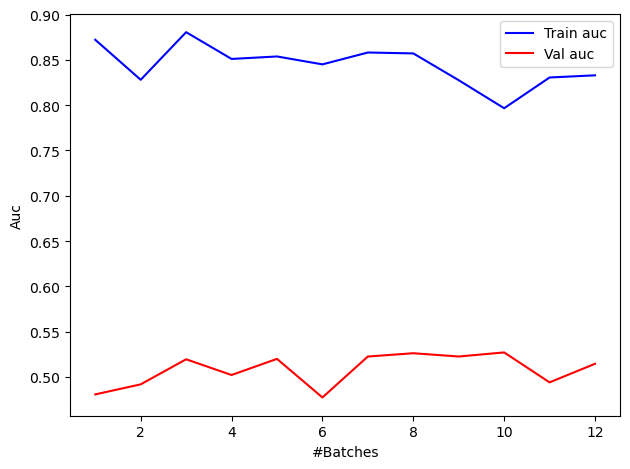

In [ ]:
# import os
# if not os.path.exists('output'):
#     os.mkdir('output')

# import matplotlib.pyplot as plt

# plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
# plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
# plt.legend(loc="best")
# plt.xlabel('#Batches')
# plt.ylabel('Auc')
# plt.tight_layout()
# plt.savefig('./output/fig-out-of-core.png', dpi=300)
# plt.show()

In [ ]:
# X_test = test_preprocess_new['Content']
# X_test = hashvec.transform(X_test)
# value = clf.predict_proba(X_test)[:,1]
# value

array([0.59867913, 0.71039762, 0.20938858, ..., 0.52613739, 0.40480274,
       0.42310348])

In [ ]:
# file = pd.concat([test[['Id']], pd.DataFrame(value, columns=['Popularity'])], axis=1)
# file

# file.to_csv('data/submission.csv', index=False)